In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import requests
import seaborn as sns
import missingno
from datetime import datetime, timedelta
import os
from os import walk
from shapely.geometry import LineString, mapping
from itertools import combinations
import re
import folium
import fiona
import pyarrow

In [12]:
nyc_gdf = gpd.read_file("./shp/taxi_zones.shp")

def clean_yellow_taxi_data(df):
    """Given a yellow taxi df applies the transformations described in Data exploration and cleaning notebook"""
    # drop duplicates
    df = df.drop_duplicates()
    
    # $1.25 for trips from LaGuardia and JFK airports
    df.loc[df["PULocationID"].
                        isin(nyc_gdf[nyc_gdf["zone"].isin(["LaGuardia Airport", "JFK Airport"])].loc[:, "LocationID"].to_list()), "airport_fee"] = 1.25
    
    # negative fares, tips, tolls, and total amount to positive
    df["fare_amount"] = abs(df.loc[:, "fare_amount"])
    df["tip_amount"] = abs(df.loc[:, "tip_amount"])
    df["tolls_amount"] = abs(df.loc[:, "tolls_amount"])
    df["total_amount"] = abs(df.loc[:, "total_amount"])
    
    # drop trips with more than 9 passengers
    df = df.drop(df[df.passenger_count > 9].index)
    
    # non-zero values of MTA_tax and Improvement_surcharge to 0.5 and 0.3 respectivelly
    df.loc[df["mta_tax"] != 0, "mta_tax"] = 0.5
    df.loc[df["improvement_surcharge"] != 0, "improvement_surcharge"] = 0.3
    
    # drop super expensive-short and super cheap-long trips
    df = df.drop(df[df.trip_distance > 4000].index)
    df = df.drop(df[df.total_amount > 100000].index)
    
    # voided trips
    df.loc[df[(df.trip_distance == 0) & (df.total_amount == 0)].index, "payment_type"] = 6
    
    # drop errors
    df = df.drop(df[(df.trip_distance == 0) & (df.payment_type != 6)].index)
    df = df.drop(df[(df.total_amount == 0) & (df.payment_type != 6)].index)
    
    # Let's create some new variables
    df["travel_time"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["travel_time_hour"] = df['travel_time'] / np.timedelta64(1, 'h')
    df["avg_speed"] = df["trip_distance"] / df["travel_time_hour"]
    df["dollar_per_mile"] = df["total_amount"] / df["trip_distance"]
    
    # drop errors
    df = df.drop(df[df.travel_time_hour <= 0].index)
    df = df.drop(df[df.travel_time_hour > 200].index)
    df = df.drop(df[df.avg_speed >= 93].index)
    
    return df
    
    

def get_cleaned_data(month_request, year):
    """Given a list of months and a year, check if the data is dowloaded or download it in order to create the df"""
    dates = [datetime(day= 1, month = month_request[month], year = year) for month in range(0,3)]
    
    taxi_trips = pd.DataFrame()
    for month in dates:
        date = str(month.year) + str("-") + str('{:02d}'.format(month.month))
        
        try:
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        except:
            url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + date + ".parquet"
            response = requests.get(url, allow_redirects=True)
            open("./data/yellow_tripdata_" + date + ".parquet", "wb").write(response.content)
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        taxi_trips = pd.concat([taxi_trips, monthly_trips])
        taxi_trips = clean_yellow_taxi_data(taxi_trips)
        return taxi_trips

In [13]:
month_request = [3, 6 ,11]
year = 2017
taxi_trips_2017 = get_cleaned_data(month_request, year)

C:\Users\berta\AppData\Local\Temp\ipykernel_50260\4092593396.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fare_amount"] = abs(df.loc[:, "fare_amount"])
C:\Users\berta\AppData\Local\Temp\ipykernel_50260\4092593396.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tip_amount"] = abs(df.loc[:, "tip_amount"])
C:\Users\berta\AppData\Local\Temp\ipykernel_50260\4092593396.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [16]:
taxi_trips_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10219911 entries, 0 to 10295440
Data columns (total 23 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   VendorID               int64          
 1   tpep_pickup_datetime   datetime64[ns] 
 2   tpep_dropoff_datetime  datetime64[ns] 
 3   passenger_count        int64          
 4   trip_distance          float64        
 5   RatecodeID             int64          
 6   store_and_fwd_flag     object         
 7   PULocationID           int64          
 8   DOLocationID           int64          
 9   payment_type           int64          
 10  fare_amount            float64        
 11  extra                  float64        
 12  mta_tax                float64        
 13  tip_amount             float64        
 14  tolls_amount           float64        
 15  improvement_surcharge  float64        
 16  total_amount           float64        
 17  congestion_surcharge   object         
 18  

<AxesSubplot:>

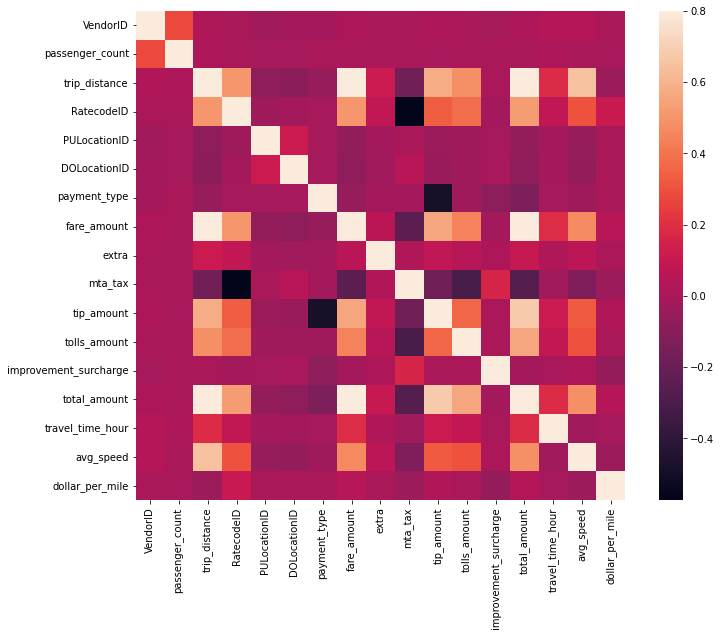

In [24]:
corrmat = taxi_trips_2017.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

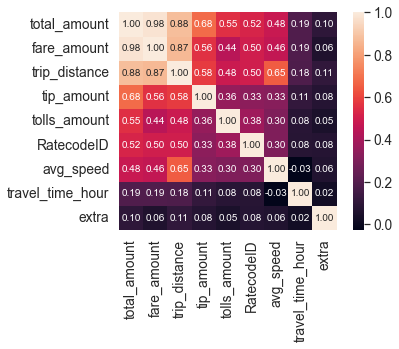

In [29]:
#saleprice correlation matrix
k = 9 #number of variables for heatmap
cols = corrmat.nlargest(k, 'total_amount')['total_amount'].index
cm = np.corrcoef(taxi_trips_2017[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

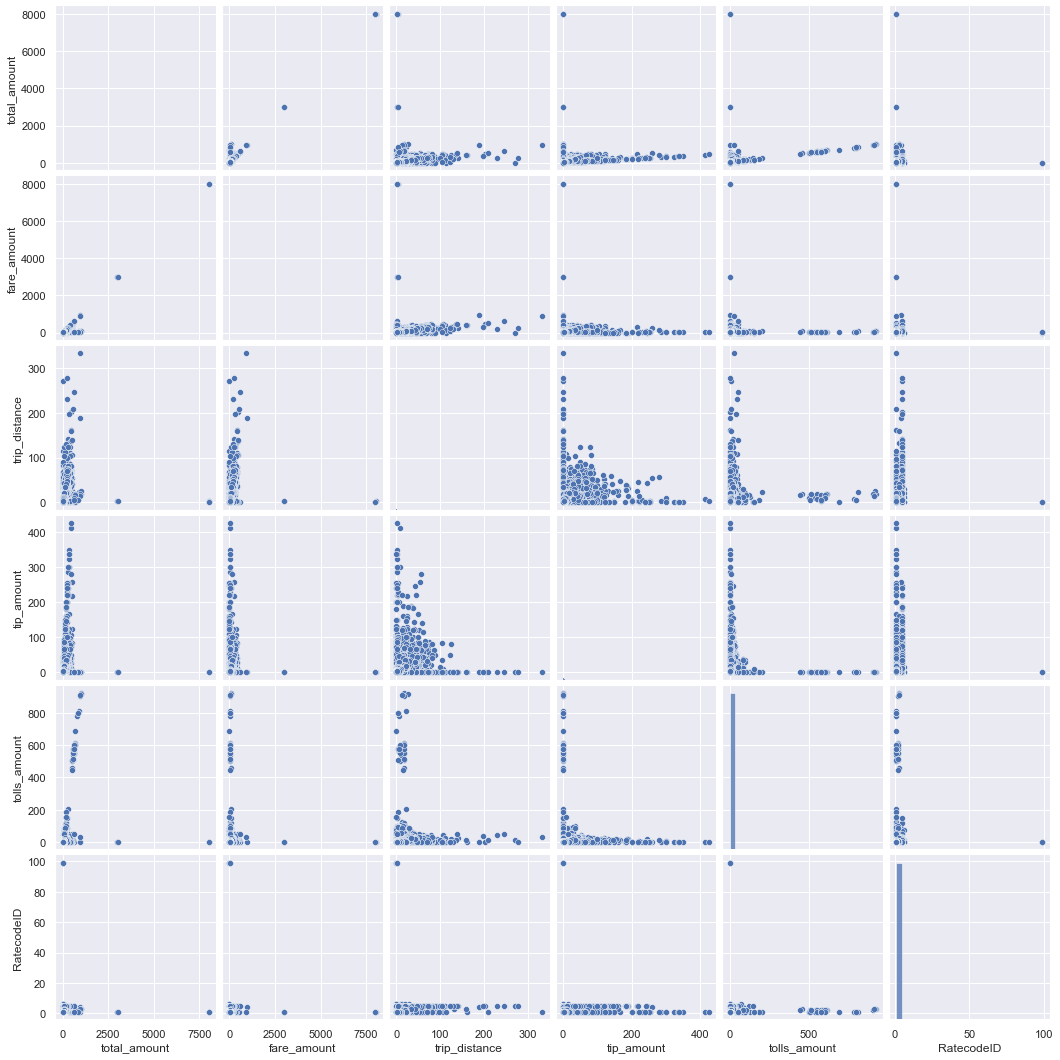

In [32]:
#scatterplot
sns.set()
cols = ['total_amount', 'fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount', 'RatecodeID']
sns.pairplot(taxi_trips_2017[cols], height = 2.5)
plt.show();

In [35]:
taxi_trips_2017.RatecodeID.unique()

array([ 1,  2,  4,  5,  3,  6, 99], dtype=int64)